# Eigenvectors and Eigenvalues

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import demoUtilities as dm
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

/home/rashed/.virtualenvs/linear-algebra/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


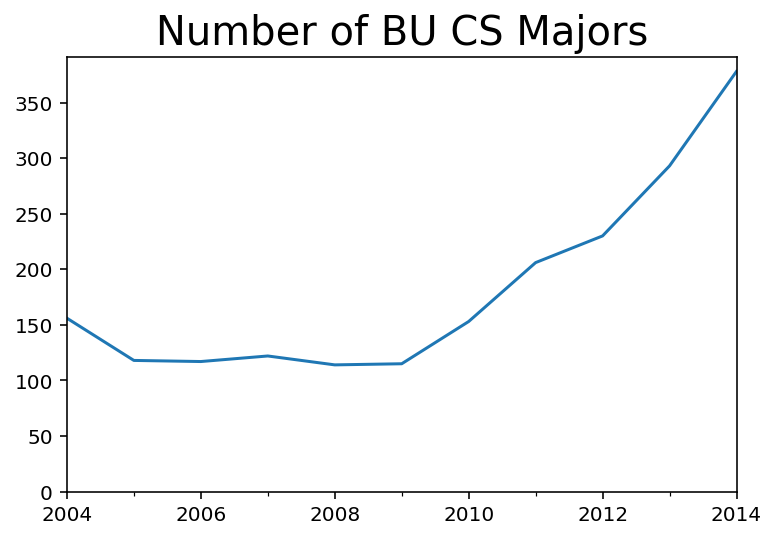

In [2]:
sl.hide_code_in_slideshow()
cohortMatrix = np.array([
[56, 42, 49, 39, 40, 31, 33, 46, 55, 91, 83],
[43, 36, 27, 34, 24, 29, 39, 56, 74, 69, 111],
[32, 24, 22, 21, 26, 25, 44, 64, 52, 77, 105],
[25, 16, 19, 28, 24, 30, 37, 40, 49, 56, 79]])
nyears = np.shape(cohortMatrix)[1]
# index rows by time, and columns by cohort    
Year = pd.DateOffset(years=1)
# need to fliplr because spreadsheet rows are in decreasing cohort order
datestrs=['09-2004','09-2005','09-2006','09-2007','09-2008','09-2009','09-2010','09-2011','09-2012','09-2013','09-2014','09-2015']
dates = [datetime.strptime(x, '%m-%Y') for x in datestrs[:nyears]]
cohorts = pd.DataFrame(np.fliplr(cohortMatrix.T),index=dates,columns=pd.Index(['U1','U2','U3','U4']))
# learning the model
b = np.array(cohorts[1:])
a = np.array(cohorts[:-1])
x, resid, rank, s = np.linalg.lstsq(a,b)
A = x.T
#
cohorts.sum(axis=1).plot()
plt.ylim(ymin=0)
# plt.legend(['Model','Actual'],loc='best')
plt.title('Number of BU CS Majors',size=20)
print('')

Currently the number of CS majors is growing very rapidly.  We'd like to have some estimate of where the numbers might be going.

Modeling the number of students in the CS major is challenging because students enter and leave the major at various points during their undergraduate degree.

We will use a simple linear model that we will train on historical data. 

Our state variable is 

$$\vx_t = \mat{{r}x_{1,t}\\ x_{2,t}\\ x_{3,t}\\ x_{4,t}}$$

where $x_{i,t}$ is the number of students who are declared CS majors and in their $i$th year at BU, in the fall of year $t$.   Our model is a linear dynamical system (or linear recurrence):

$$ \vx_{t+1} = A \vx_t.$$

Given historical data which are measurements of our state variable from past years, we can estimate $A$ by a method called _least squares_ (which we will cover later in the semester.)

To give you a sense of how the number of students of different classes varies depending on the situation, here are three examples, corresponding to shrinking, early growth, and steady growth:

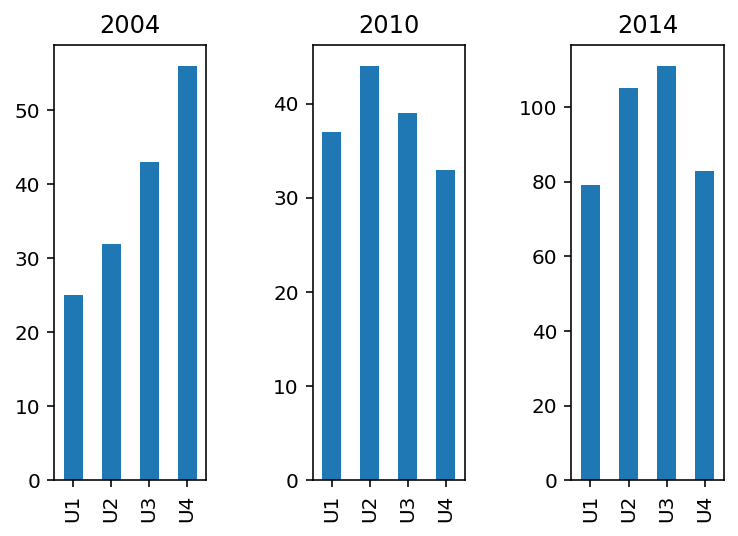

In [3]:
sl.hide_code_in_slideshow()
plt.subplot(1,3,1)
cohorts.iloc[0].plot(kind='bar')
plt.title(cohorts.index[0].strftime('%Y'))
plt.subplot(1,3,2)
cohorts.iloc[6].plot(kind='bar')
plt.title(cohorts.index[6].strftime('%Y'))
plt.subplot(1,3,3)
cohorts.iloc[10].plot(kind='bar')
plt.title(cohorts.index[10].strftime('%Y'))
plt.subplots_adjust(wspace=0.7)
print('')

So, given enough historical information in the form of this state vector over previous years, we can in fact make accurate predictions of number of CS majors:

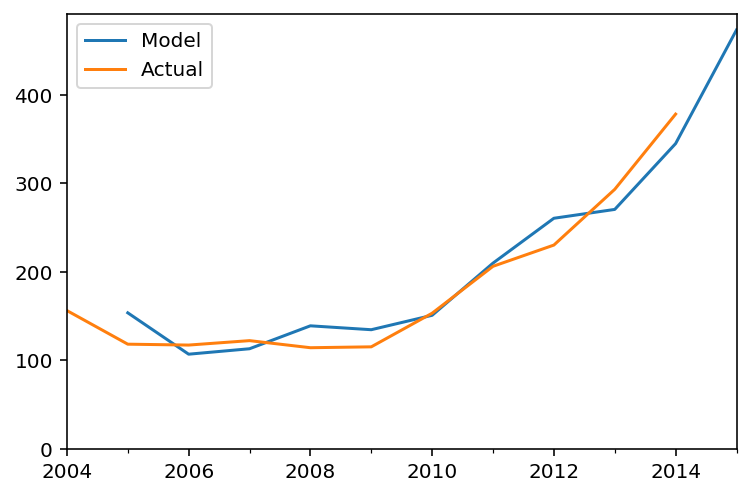

In [4]:
sl.hide_code_in_slideshow()
OneYearAhead = cohorts.dot(A.T).shift(1,freq=Year)
OneYearAhead.columns=pd.Index(['U1','U2','U3','U4'])
OneYearAhead.sum(axis=1).plot()
cohorts.sum(axis=1).plot()
plt.ylim(ymin=0)
plt.legend(['Model','Actual'],loc='best')
print('')

Besides predicting next year's class sizes, analyzing this model can help us answer other important questions: 

1. If CS major enrollments were at steady-state, how many students will be Freshmen, Sophomores, etc?  (This impacts course offerings).
2. If the CS major were at steady-state, how many students would be graduating each year?
3. What is the intrinsic growth rate predicted by this model?

Today's lecture will start to develop the tools to answer such questions (and more).

## Eigenvectors and Eigenvalues

The system above is an example of a linear transformation $\vx\mapsto A\vx.$  

As we've seen, such transformations, thinking geometrically, can move a vector to a new location.

Let's start with a simple example: a __shear__ matrix:

$$ A = \mat{{rr}1&0.1\\0&1} $$

Let's look at what this matrix does to each point in the plane.

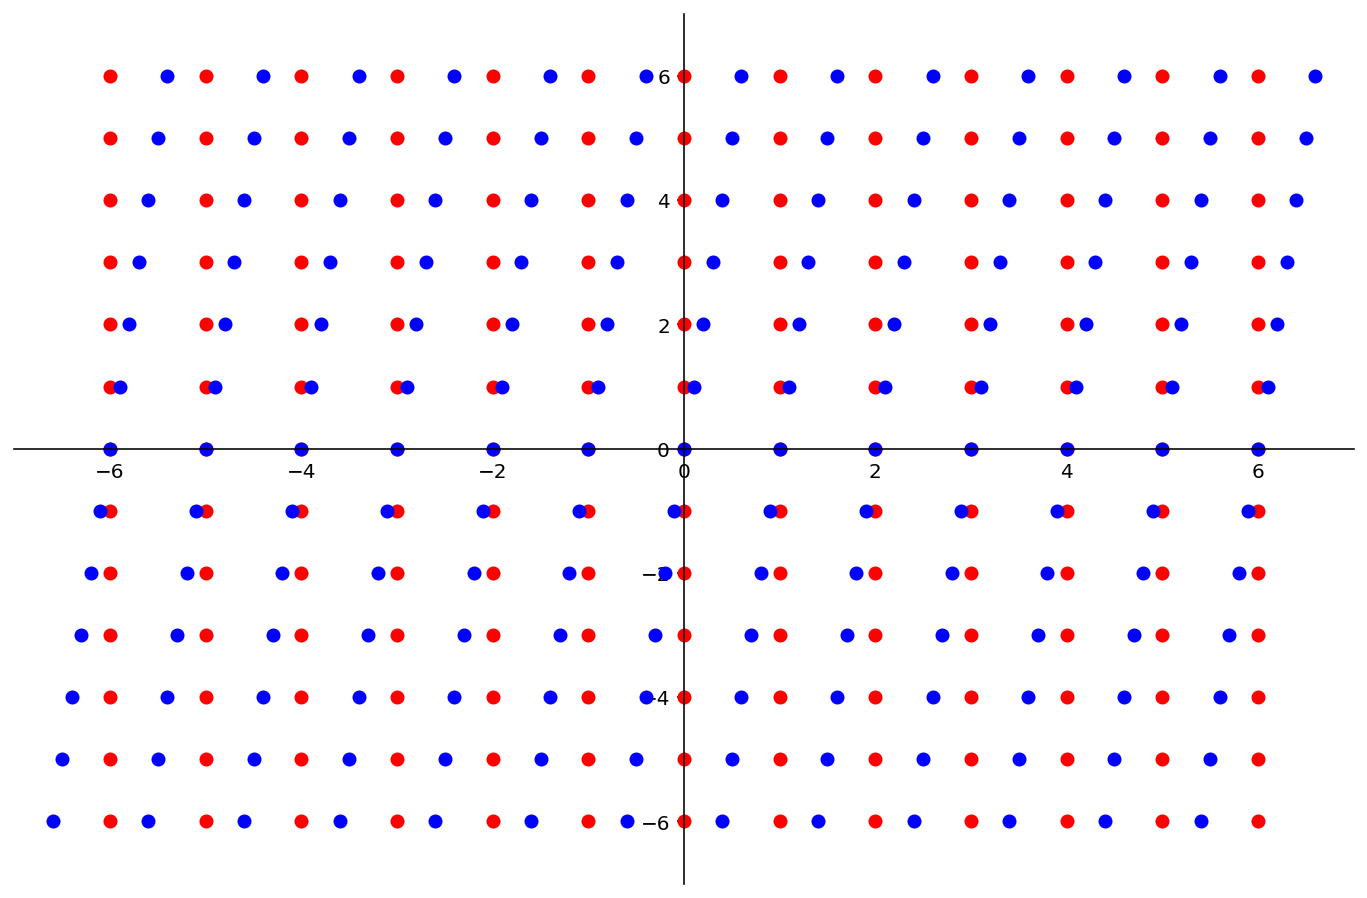

In [5]:
A = np.array([[1, 0.1],
              [0,   1]])
ax = ut.plotSetup(-7,7,-7, 7, size=(12,8))
ut.centerAxes(ax)
for x in range(-6,7):
    for y in range(-6,7):
        v = np.array([x,y])
        ut.plotVec(ax, v)
        ut.plotVec(ax, A.dot(v),'b')

We can use arrows to show how each red point is moved to the corresponding blue point.

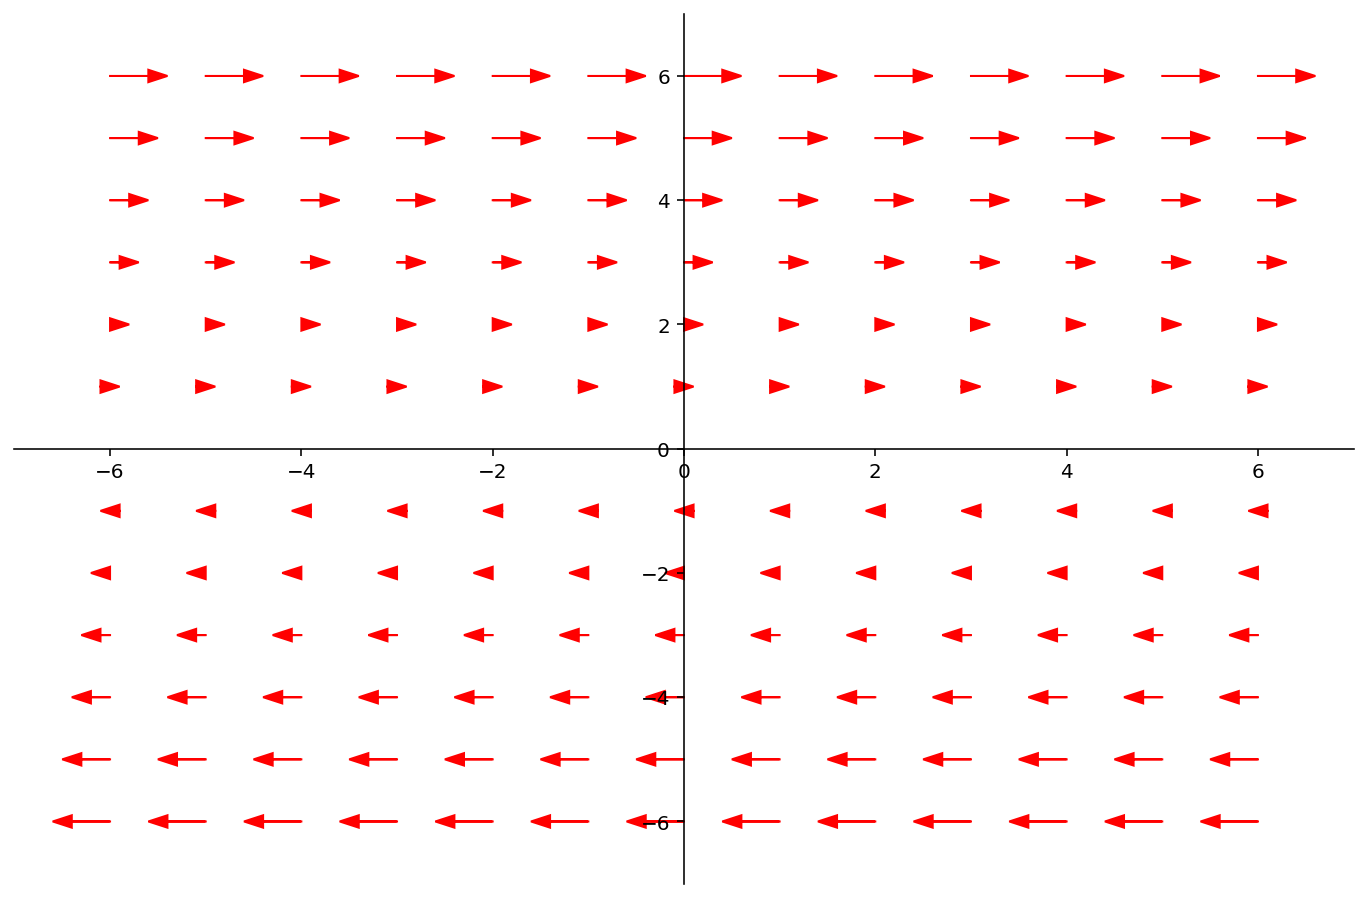

In [6]:
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-7,7,-7, 7, size=(12,8))
ut.centerAxes(ax)
A = np.array([[1,0.1],[0,1]])
for x in range(-6,7):
    for y in range(-6,7):
        ut.plotArrowVec(ax, A.dot(np.array([x,y])), [x,y])

Now let's look at a more complicated situation.

Consider the matrix $A = \mat{{rr}1.0&0.2\\0.1&0.9}$.

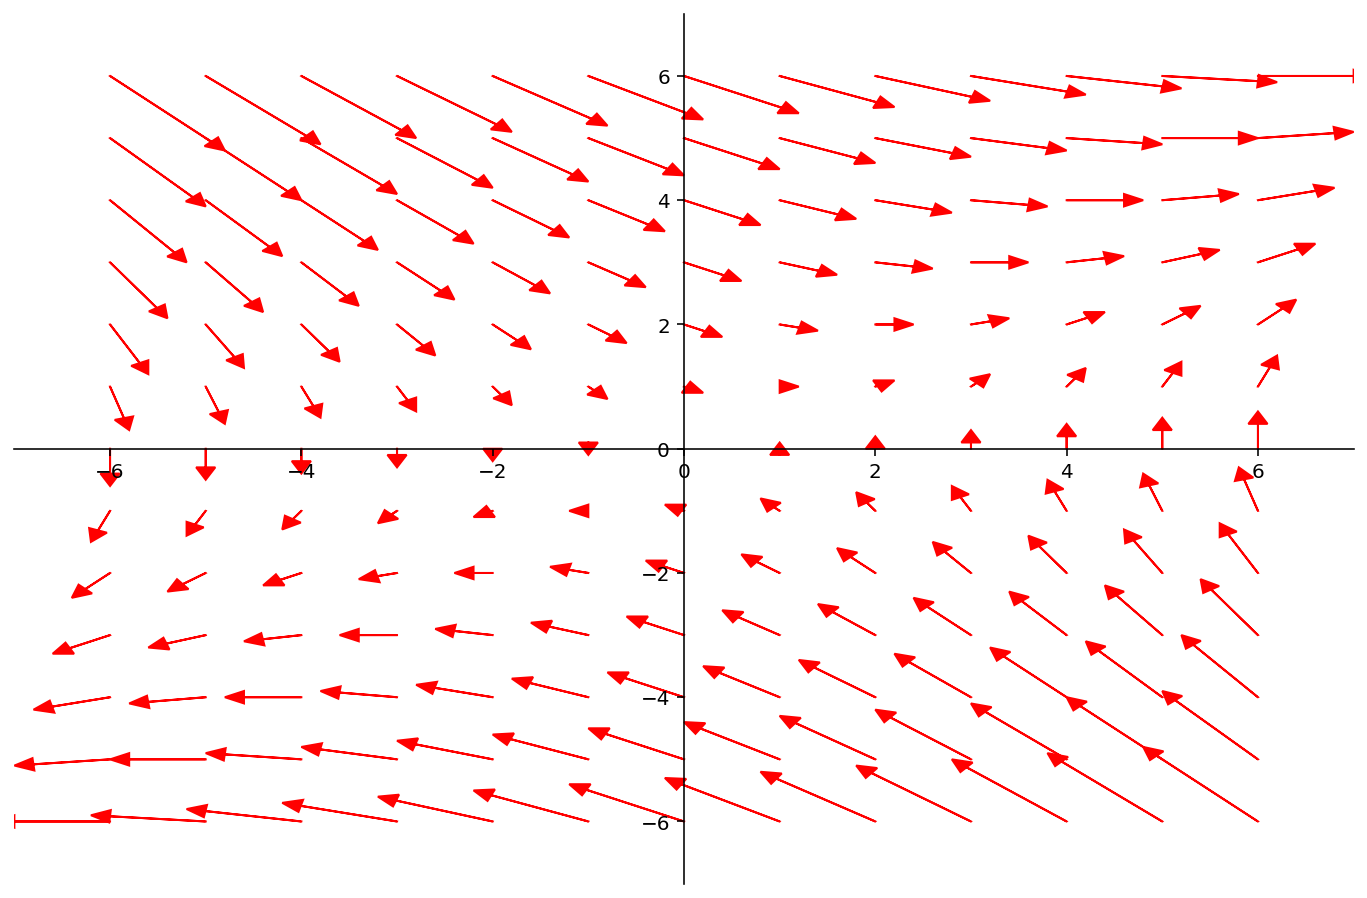

In [7]:
sl.hide_code_in_slideshow()
V = np.array([[2,-1],[1,1]])
L = np.array([[1.1,0],
              [0,0.8]])
A = V.dot(L).dot(np.linalg.inv(V))
ax = ut.plotSetup(-7,7,-7, 7, size=(12,8))
ut.centerAxes(ax)
for x in range(-6,7):
    for y in range(-6,7):
        v = np.array([x,y])
        ut.plotArrowVec(ax, A.dot(v), v)

The starting point for understanding such systems is to look for special vectors which __do not change their direction__ when multiplied by $A$.

__Example.__

Let $A = \mat{{rr}3&-2\\1&0}, \vu = \mat{{r}-1\\1}, \vv=\mat{{r}2\\1}.$  The images of $\vu$ and $\vv$ under multiplication by $A$ are shown here:

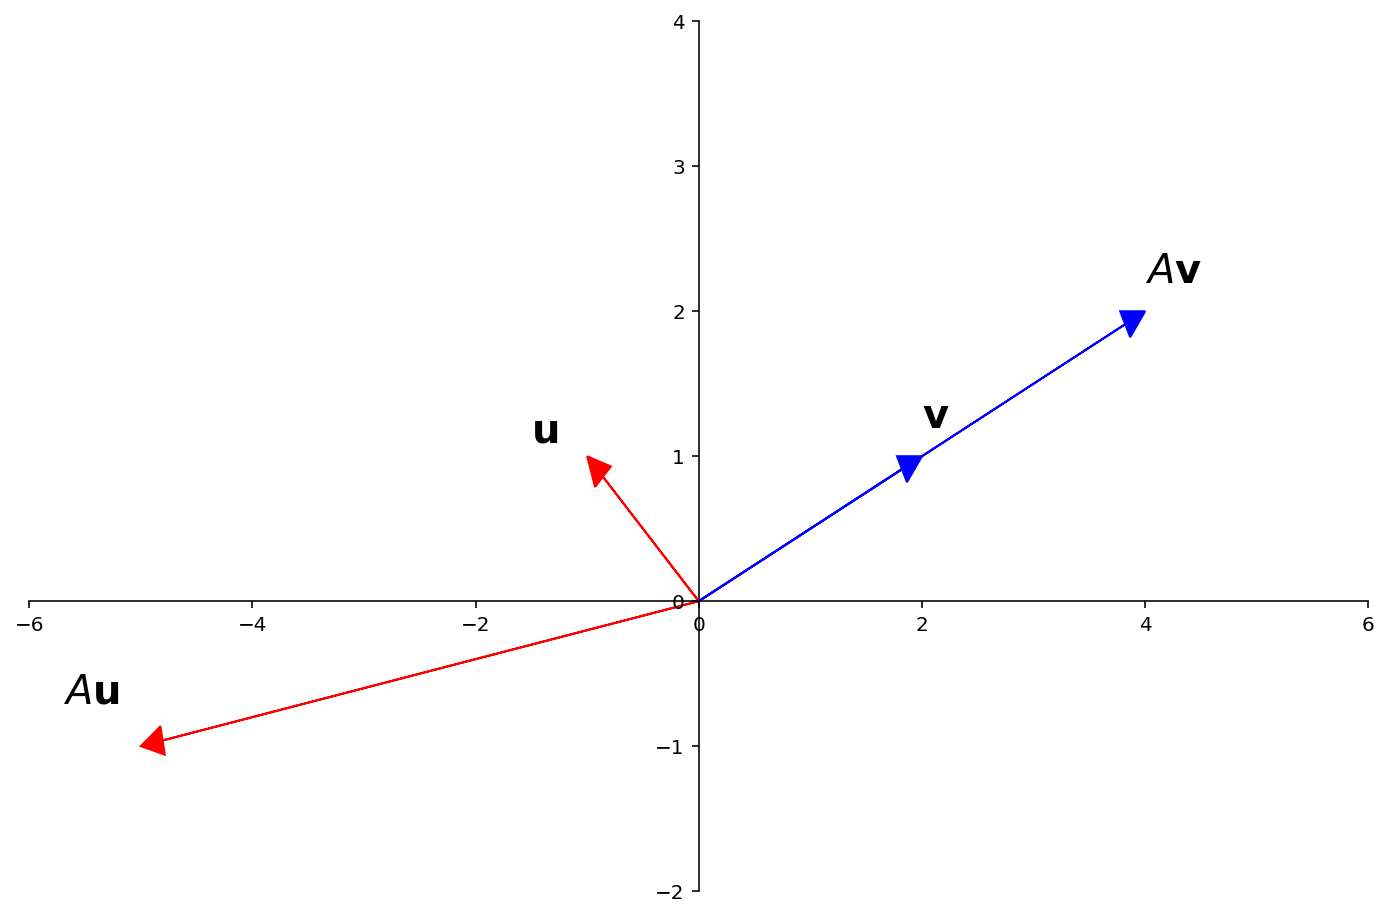

In [8]:
sl.hide_code_in_slideshow()
reload(ut)
ax = ut.plotSetup(size=(12,8))
ut.centerAxes(ax)
A = np.array([[3,-2],[1,0]])
u = np.array([-1,1])
v = np.array([2,1])
#
ut.plotArrowVec(ax, v, [0,0], color='Blue')
ut.plotArrowVec(ax, A.dot(v), [0,0], color='Blue')
ax.text(v[0],v[1]+0.2,r'${\bf v}$',size=20)
ax.text(A.dot(v)[0],A.dot(v)[1]+0.2,r'$A{\bf v}$',size=20)
#
ut.plotArrowVec(ax, u, [0,0], color='Red')
ut.plotArrowVec(ax, A.dot(u), [0,0], color='Red')
ax.text(u[0]-0.5,u[1]+0.1,r'${\bf u}$',size=20)
ax.text(A.dot(u)[0]-0.7,A.dot(u)[1]+0.3,r'$A{\bf u}$',size=20)
print('')

For a "typical" vector (like $\vu$) the action of $A$ is to scale, reflect, and/or rotate it.  

But for some special vectors (like $\vv$) the action of $A$ is only to "stretch" it (without any rotation or reflection).

In fact, $A\vv$ is simply $2\vv.$

Today we will by studying equations such as 

$$ A\vx = 2\vx\;\;\;\;\mbox{or}\;\;\;\;A\vx = -4\vx$$

where special vectors are transformed by $A$ into scalar multiples of themselves.

__Definition.__  

An __eigenvector__ of an $n\times n$ matrix $A$ is a nonzero vector $\vx$ such that $A\vx = \lambda\vx$ for some scalar $\lambda.$  

A scalar $\lambda$ is called an __eigenvalue__ of $A$ if there is a nontrivial solution $\vx$ of $A\vx = \lambda\vx.$  

Such an $\vx$ is called an _eigenvector corresponding to $\lambda.$_

## Checking Eigenvectors and Eigenvalues

Before considering how to compute eigenvectors, let's look at simply how to determine if a given vector is an eigenvector of a matrix.

__Example.__  Let $A = \mat{{rr}1&6\\5&2}, \vu = \mat{{r}6\\-5}, \vv=\mat{{r}3\\-2}.$  

Are $\vu$ and $\vv$ eigenvectors of $A$?

__Solution.__

$$A\vu = \mat{{rr}1&6\\5&2}\mat{{r}6\\-5} = \mat{{r}-24\\20} = -4\mat{{r}6\\-5} = -4\vu.$$

$$A\vv = \mat{{rr}1&6\\5&2}\mat{{r}3\\-2} = \mat{{r}-9\\11} \neq \lambda\mat{{r}3\\-2}.$$

So $\vu$ is an eigenvector corresponding to the eigenvalue $-4$, but $\vv$ is not an eigenvector of $A$.

__Example.__   Show that 7 is an eigenvalue of the matrix $A$, and find the corresponding eigenvectors.

For 7 to be an eigenvalue of $A$, it must be the case that 

$$ A\vx=7\vx$$

has a nontrivial solution.

This is equivalent to:

$$ A\vx - 7\vx = {\bf 0}$$

or 

$$ (A - 7I)\vx = {\bf 0}.$$

To solve this homogeneous equation, form the matrix

$$A - 7I = \mat{{rr}1&6\\5&2}-\mat{{rr}7&0\\0&7} = \mat{{rr}-6&6\\5&-5}.$$

The columns of $A-7I$ are obviously linearly dependent, so $(A - 7I)\vx = {\bf 0}$ has a nontrivial solution.

So 7 is an eigenvalue of $A$.

To find the corresponding eigenvectors, we solve $(A - 7I)\vx = {\bf 0}$ using row operations:

$$\mat{{rrr}-6&6&0\\5&-5&0}\sim\mat{{rrr}1&-1&0\\0&0&0}.$$

This says that $x_1 = x_2,$ and $x_2$ is free.

So the general solution has the form $x_2\mat{{r}1\\1}.$  Each vector of this form with $x_2 \neq 0$ is an eigenvector corresponding to $\lambda = 7.$

## Question TIme! Q16.1

## Eigenspace

Clearly, $\lambda$ is an eigenvalue of an $n\times n$ matrix $A$ if and only if the equation

$$(A-\lambda I)\vx = {\bf 0}$$

has a nontrivial solution.

Notice that the set of _all_ solutions of that equation is just _the null space of the matrix $A-\lambda I.$_

So the set of all eigenvectors corresponding to a particular $\lambda$ is a _subspace of $\R^n$_ and is called the __eigenspace__ of $A$ corresponding to $\lambda$.

__Example.__  For matrix $A = \mat{{rr}1&6\\5&2},$ we found that the general solution for the eigenvector corrsponding to $\lambda = 7$ is the expression $\vx_1\mat{{r}1\\1}.$  

This means that the eigenspace corresponding to $\lambda = 7$ consists of all multiples of $\mat{{r}1\\1},$ which is the line through $(1,1)$ and the origin.

We could also show that the eigenspace corresponding to $\lambda = -4$ is the line through $(-6,5)$.

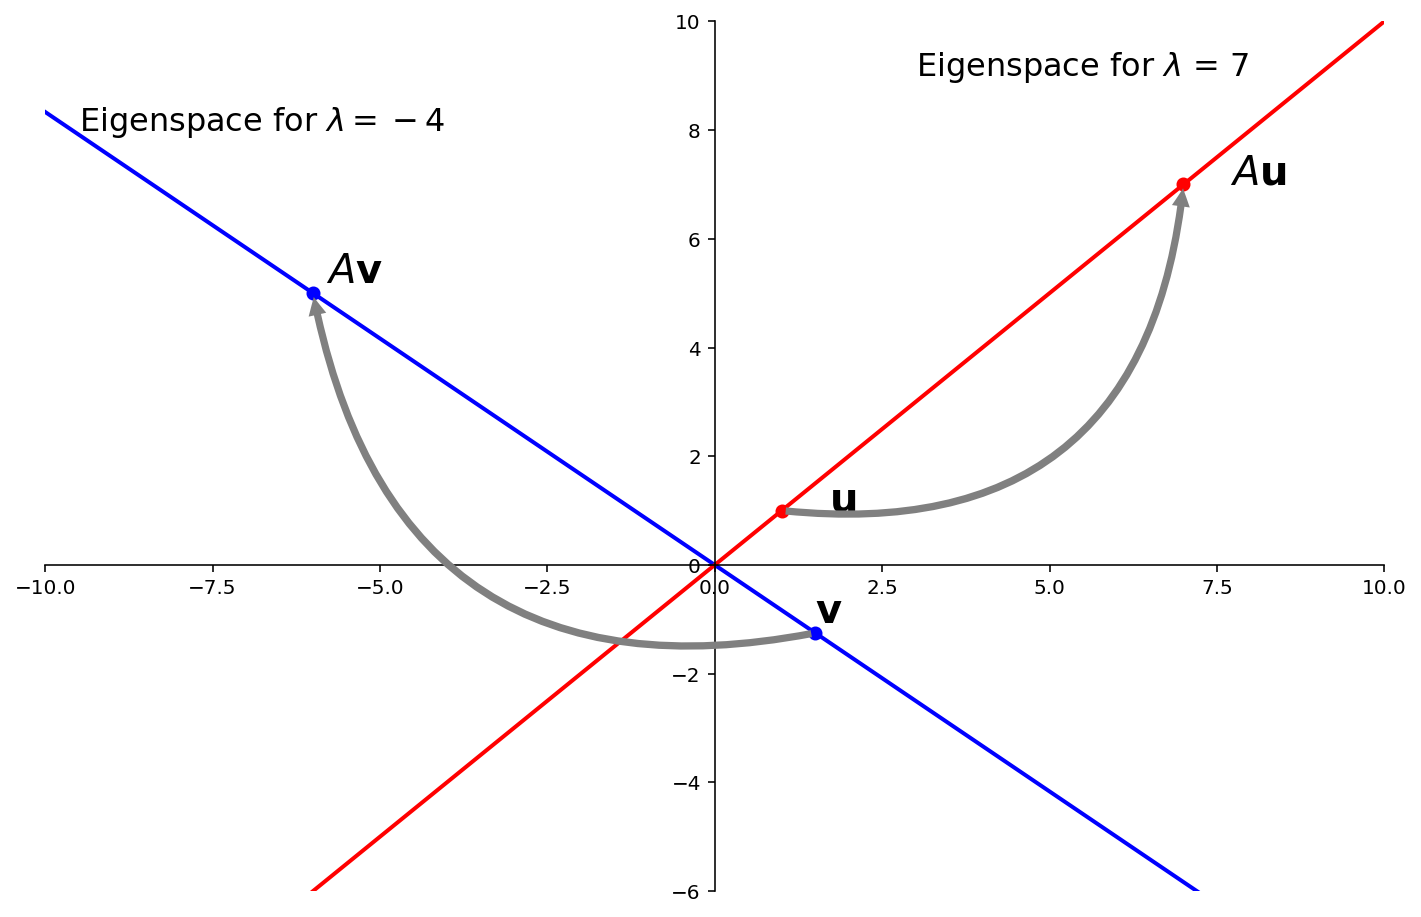

In [9]:
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-10,10,-6,10,size=(12,8))
ut.centerAxes(ax)
A = np.array([[1,6],[5,2]])
u = np.array([1,1])
v = np.array([3./2,-5./4])
#
ax.plot(v[0],v[1],'bo')
ax.plot(A.dot(v)[0],A.dot(v)[1],'bo')
ax.text(v[0],v[1]+0.2,r'${\bf v}$',size=20)
ax.text(A.dot(v)[0]+0.2,A.dot(v)[1]+0.2,r'$A{\bf v}$',size=20)
ax.plot([-10,10],[5*10/6.0,-5*10/6.0],'b-',lw=2)
#
ax.plot(u[0],u[1],'ro')
ax.plot(A.dot(u)[0],A.dot(u)[1],'ro')
ax.text(u[0]+0.7,u[1],r'${\bf u}$',size=20)
ax.text(A.dot(u)[0]+0.7,A.dot(u)[1],r'$A{\bf u}$',size=20)
ax.plot([-6,10],[-6,10],'r-',lw=2)
# 
ax.annotate('', xy=(A.dot(u)[0], A.dot(u)[1]),  xycoords='data',
                xytext=(u[0], u[1]), textcoords='data',
                size=18,
                #bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops={'arrowstyle': 'simple',
                                'fc': '0.5', 
                                'ec': 'none',
                                'connectionstyle' : 'arc3,rad=0.5'},
                )
ax.annotate('', xy=(A.dot(v)[0], A.dot(v)[1]),  xycoords='data',
                xytext=(v[0], v[1]), textcoords='data',
                size=18,
                #bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops={'arrowstyle': 'simple',
                                'fc': '0.5', 
                                'ec': 'none',
                                'connectionstyle' : 'arc3,rad=-0.5'},
                )
ax.text(3,9,r'Eigenspace for $\lambda$ = 7',size=16)
ax.text(-9.5,8,r'Eigenspace for $\lambda = -4$',size=16)
print('')

__Example.__  Let $A = \mat{{rrr}4&-1&6\\2&1&6\\2&-1&8}.$  An eigenvalue of $A$ is $2.$  Find a basis for the the corresponding eigenspace.

__Solution.__  The eigenspace we are looking for is the nullspace of $A - 2I.$  

We will use the strategy for finding a basis for a nullspace that we learned in the last lecture.

Form

$$A - 2I = \mat{{rrr}4&-1&6\\2&1&6\\2&-1&8}-\mat{{rrr}2&0&0\\0&2&0\\0&0&2} = \mat{{rrr}2&-1&6\\2&-1&6\\2&-1&6}$$

and row reduce the augmented matrix for $(A-2I)\vx={\bf 0}$:

$$\mat{{rrrr}2&-1&6&0\\2&-1&6&0\\2&-1&6&0} \sim \mat{{rrrr}2&-1&6&0\\0&0&0&0\\0&0&0&0}$$

At this point, it is clear that 2 is indeed an eigenvalue of $A$ because the equation $(A-2I)\vx = {\bf 0}$ has free variables.  

The general solution is $x_1 = \frac{1}{2}x_2 +-3x_3.$

Expressed as a vector, the general solution is:

$$\mat{{c}\frac{1}{2}x_2 - 3x_3\\x_2\\x_3}.$$

Expressed as a vector sum, this is:

$$x_2\mat{{c}1/2\\1\\0} + x_3\mat{{r}-3\\0\\1}\;\;\;\;\mbox{with $x_2$ and $x_3$ free.}$$

So this eigenspace is a two-dimensional subspace of $\R^3,$ and a basis for this subspace is

$$\left\{\mat{{c}1/2\\1\\0},\mat{{r}-3\\0\\1}\right\}.$$

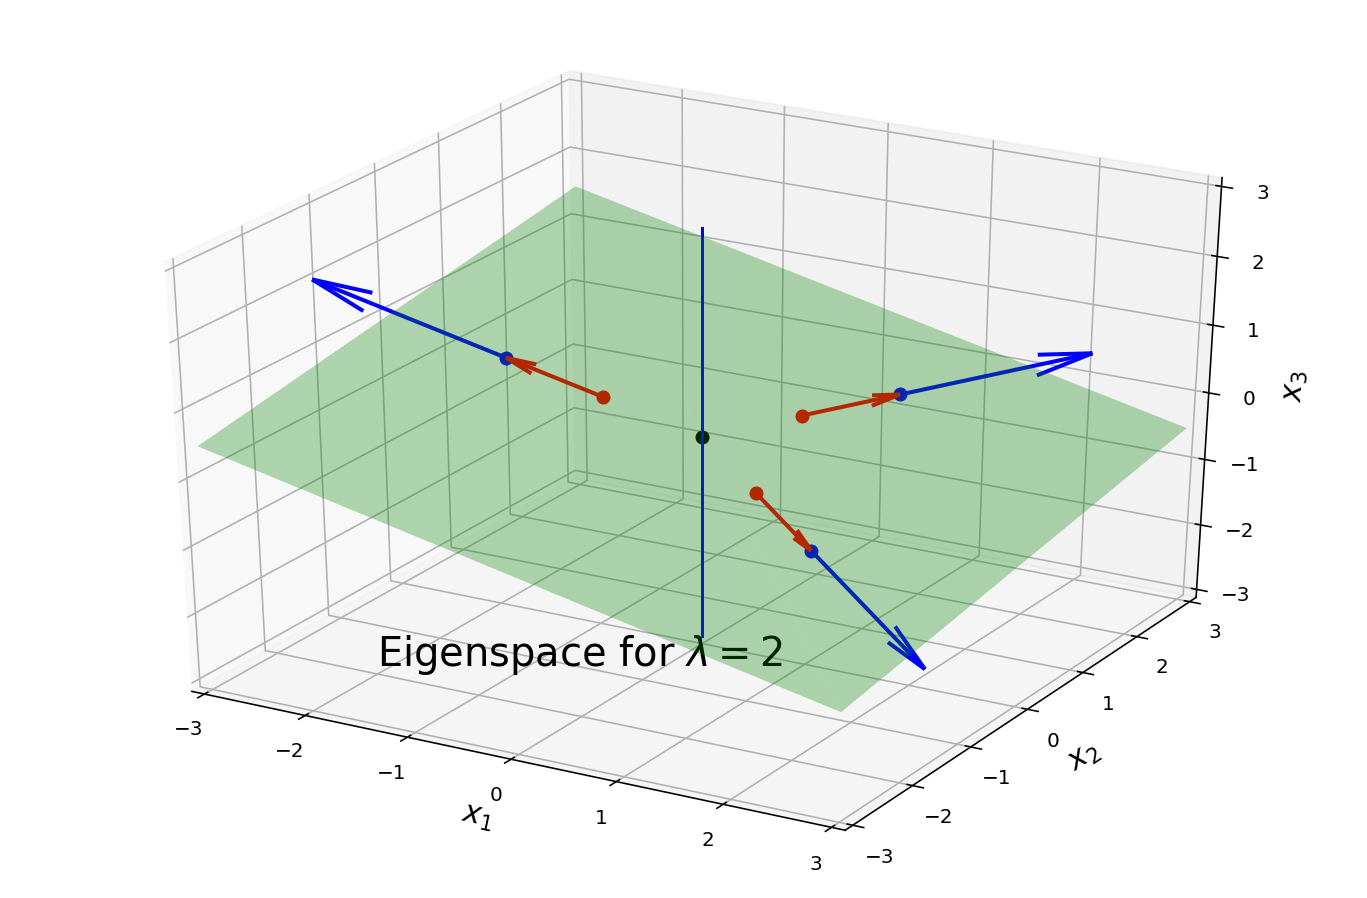

In [10]:
sl.hide_code_in_slideshow()
ax = ut.plotSetup3d(-3,3,-3,3,-3,3,figsize=(12,8))
v = np.array([1.,2.,0])
v = v/np.sqrt(np.sum(v*v))
u = np.array([-3.0,0,1.0])
u = u/np.sqrt(np.sum(u*u))
w = -v-2.0*u
w = w/np.sqrt(np.sum(w*w))
pts = np.array([v,u,w])
#ax.text(v[0],v[1],v[2],r'$\bf v$',size=20)
#ax.text(u[0],u[1],u[2],r'$\bf u$',size=20)
ax.text(-2,-2,-3,r'Eigenspace for $\lambda=2$',size=20)
#ax.text(0.2,0.2,-4,r'$\bf 0$',size=20)
# plotting the span of v
ut.plotSpan3d(ax,u,v,'Green')
ut.plotPoint3d(ax,u[0],u[1],u[2],'r')
ut.plotPoint3d(ax,v[0],v[1],v[2],'r')
ut.plotPoint3d(ax,w[0],w[1],w[2],'r')
ut.plotPoint3d(ax,0,0,0,'k')
plt.quiver(pts[:,0],pts[:,1],pts[:,2],pts[:,0],pts[:,1],pts[:,2],length=1.0,color='Red',lw=2)
pts = 2.0*pts
plt.quiver(pts[:,0],pts[:,1],pts[:,2],pts[:,0],pts[:,1],pts[:,2],length=1.0,color='Blue',lw=2)
u = 2*u
v = 2*v
w = 2*w
ut.plotPoint3d(ax,u[0],u[1],u[2],'b')
ut.plotPoint3d(ax,v[0],v[1],v[2],'b')
ut.plotPoint3d(ax,w[0],w[1],w[2],'b')
# plotting the axes
# ut.plotIntersection3d(ax,[0,0,1,0],[0,1,0,0])
# ut.plotIntersection3d(ax,[0,0,1,0],[1,0,0,0])
ut.plotIntersection3d(ax,[0,1,0,0],[1,0,0,0])
print('')

## Question Time! Q16.2

## Eigenvalues of a Triangular Matrix

__Theorem.__  The eigenvalues of a triangular matrix are the entries on its main diagonal.

__Proof.__  We'll consider the $3\times 3$ case.  If $A$ is upper triangular, then $A-\lambda I$ has the form

$$A - \lambda I = \mat{{rrr}a_{11}&a_{12}&a_{13}\\0&a_{22}&a_{23}\\0&0&a_{33}} - \mat{{rrr}\lambda&0&0\\0&\lambda&0\\0&0&\lambda}$$

$$ = \mat{{ccc}a_{11}-\lambda&a_{12}&a_{13}\\0&a_{22}-\lambda&a_{23}\\0&0&a_{33}-\lambda}$$

Now, $\lambda$ is an eigenvalue of $A$ if and only if the equation $(A-\lambda I)\vx = {\bf 0}$ has a nontrivial solution -- in other words, if an only if the equation has a free variable.

The special pattern that the zero entries have in $A$ means that there will be a free variable if any diagonal entry is also zero, because then there will be a column without a pivot.

That is, $(A-\lambda I)\vx = {\bf 0}$ has a free variable if and only if at least one of the entries on the diagonal of $(A-\lambda I)$ is zero.

This happens if and only if $\lambda$ equals one of the entries $a_{11}, a_{22},$ or $a_{33}$ on the diagonal of $A$.

__Example.__  Let $A = \mat{{rrr}3&6&-8\\0&0&6\\0&0&2}$ and $B = \mat{{rrr}4&0&0\\-2&1&0\\5&3&4}$.

Then the eigenvalues of $A$ are 3, 0, and 2.   The eigenvalues of $B$ are 4 and 1.

## Invertibility and Eigenvalues

So far we haven't probed what it means for a matrix to have an eigenvalue of 0.

This happens if and only if the equation $A\vx = 0\vx$ has a nontrivial solution.

But that equation is equivalent to $A\vx = {\bf 0}$ which has a nontrivial solution if and only if $A$ is not invertible.

This means that _0 is an eigenvalue of $A$ if and only if $A$ is not invertible._

This draws an important connection between invertibility and zero eigenvalues.

So we have __yet another__ addition to the Invertible Matrix Theorem!

## Question Time! Q16.3

## Eigenvectors and Difference Equations

Let's return to the problem we considered at the outset: predicting future values of $\vx_t$ (the number of CS majors of each class in year $t$).

We modeled the future as $\vx_{t+1} = A\vx_t\;\;\;(t = 0,1,2,\dots).$

A __solution__ of such an equation is an explicit description of $\{\vx_t\}$ whose formula for each $\vx_t$ does not depend directly on $A$ or on the preceding terms in the sequence other than the initial term $\vx_0.$

The simplest way to build a solution is to take an eigenvector $\vx_0$ and its corresponding eigenvalue $\lambda$ and let 
$$ \vx_t = \lambda^t \vx_0 \;\;\;(t = 0,1,2,\dots)$$

This sequence is a solution because 
$$A\vx_t = A(\lambda^t\vx_0) = \lambda^t(A\vx_0) = \lambda^k(\lambda\vx_0) = \lambda^{t+1}\vx_0 = \vx_{t+1}.$$

We can extend this to combinations of eigenvectors.   

If $A$ has two eigenvectors $\vu$ and $\vv$ corresponding to eigenvalues $\lambda$ and $\mu$,
then another solution is 

$$ x_t = \lambda^t\vu + \mu^t \vv$$

To address the problem of predicting the CS major population, we assume that we can express the state vector $\vx$ as a linear combination of eigenvectors $\vu_1, \vu_2, \dots,\vu_p$.  (In fact this is always possible.)  That is, 

$$\vx_0 = a_1\vu_1 + a_2\vu_2+\dots+a_p\vu_p.$$

Then at time $t$, 

$$\vx_t = \lambda_1^ta_1\vu_1 + \lambda_2^ta_2\vu_2 + \dots + \lambda_p^ta_p\vu_p.$$

Which gives us an explicit solution for the number of students in the major in any future year.

Note that the expression above is exponential in each of the $\lambda_1,\dots,\lambda_p$.  

The resulting value will be essentially determined by the largest $\lambda_i$.   

To see this, let's say that $\lambda_1$ is the largest eigenvalue, and $\lambda_2$ is the second largest.   

Then the proportion of $\vu_1$ to $\vu_2$ contained in $\vx_t$ will be given by $(\lambda_1/\lambda_2)^t$.   

Since this ratio is larger than 1, the relative proportion of $\vu_1$ will grow exponentially.  

This shows the importance of the largest eigenvalue in the value of $\vx_t$ for large $t$.  In the long run, $\vx_t$ will be very close to $\lambda_1^t\vu_1.$

The largest eigenvalue shows the asymptotic rate of growth (or shrinkage) of the state vector $\vx_t$.

For the matrix $A$ that describes CS major population growth, the largest eigenvalue is 1.19.  

In fact, the incoming class (fall 2015) shows an increase in stated interest in CS of about 20%!